### Model compression

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-10-12 15:40:00.559152: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 15:40:00.595517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-12 15:40:01.130690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  0


2025-10-12 15:40:02.262514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-10-12 15:40:02.262547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mareKaleido
2025-10-12 15:40:02.262552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mareKaleido
2025-10-12 15:40:02.262683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2025-10-12 15:40:02.262701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2025-10-12 15:40:02.262705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

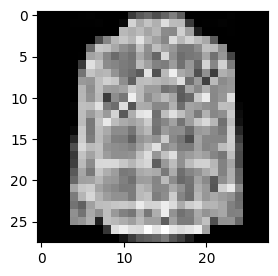

In [4]:
# Image index

N = 32

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [5]:
# Labels
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Load model



In [6]:
model = load_model('../models/fashionMNIST.h5')

2025-10-12 15:40:02.816809: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21c12c30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-12 15:40:02.816842: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-trai

In [8]:
n_classes = 10
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Pruning

In [10]:
epochs = 64
batch = 64
lr = 0.0001
op = Adam(lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
val_split = 0.2

final_sparsity = 0.2


## PolynomialDecay: gradually increases the sparsity of a model over time using a polynomial function. 
# This helps in iterative pruning, where pruning is applied progressively rather than all at once, 
# improving accuracy retention.

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=90*2, end_step=90*63
                )
            }

In [11]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

### Model training

In [12]:
history = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/64
750/750 [==============================] - 3s 2ms/step - loss: 0.4461 - accuracy: 0.8452 - val_loss: 0.4064 - val_accuracy: 0.8572
Epoch 2/64
750/750 [==============================] - 2s 2ms/step - loss: 0.4094 - accuracy: 0.8566 - val_loss: 0.3847 - val_accuracy: 0.8628
Epoch 3/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3847 - accuracy: 0.8644 - val_loss: 0.3706 - val_accuracy: 0.8707
Epoch 4/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3649 - accuracy: 0.8705 - val_loss: 0.3615 - val_accuracy: 0.8719
Epoch 5/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3505 - accuracy: 0.8760 - val_loss: 0.3464 - val_accuracy: 0.8778
Epoch 6/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3362 - accuracy: 0.8800 - val_loss: 0.3440 - val_accuracy: 0.8764
Epoch 7/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3265 - accuracy: 0.8841 - val_loss: 0.3404 - val_accuracy: 0.8756
Epoch 

In [13]:
# Model evaluation
test_loss, test_acc = modelP.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 0s 806us/step - loss: 0.3550 - accuracy: 0.8985

Test accuracy: 0.8985


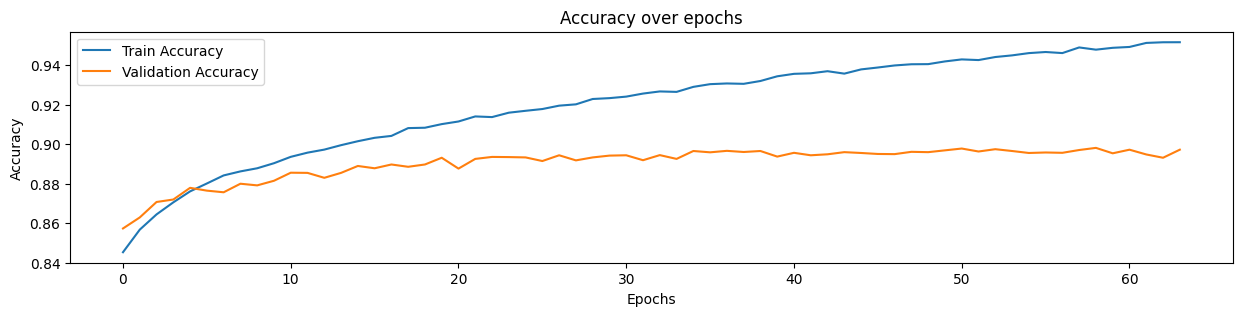

In [14]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

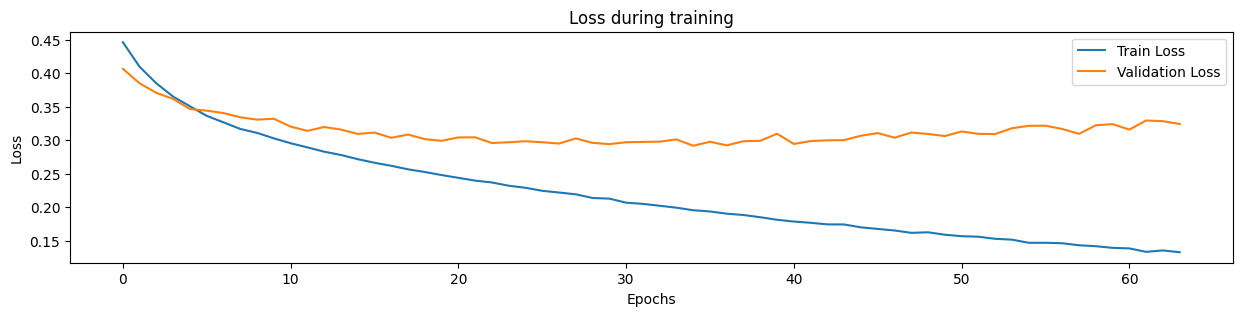

In [15]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Confusion Matrix

313/313 [==============================] - 0s 689us/step


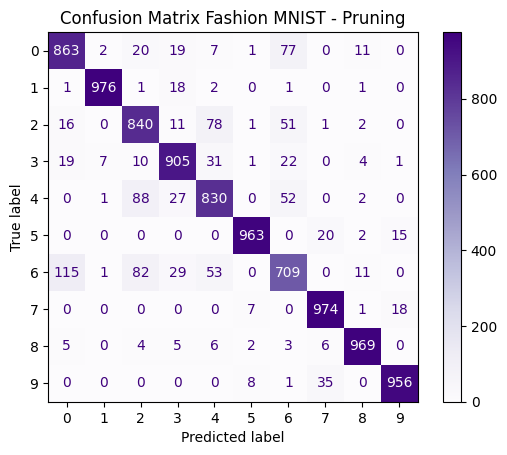

In [16]:
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix Fashion MNIST - Pruning')
plt.show()


### Quantization-aware training

QDense: A quantized version of Dense.

quantized_bits(N, M):

- N: Total bits used.

- M: Bits for the integer part.

QActivation: Applies quantized activations such as quantized_relu and quantized_softmax.

In [17]:
# El punto fijo representa números decimales con precisión limitada, usando una cantidad fija de bits para la parte entera y la fraccionaria.
# Es más simple y rápido que el punto flotante, pero menos flexible.

kernelQ = "quantized_bits(8,4, alpha=1)"
biasQ = "quantized_bits(8, 4,  alpha=1)"
activationQ = 'quantized_bits(8, 4)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(250, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(100, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(50, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

/tools/anaconda3/envs/neuralEnv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [18]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 250)               196250    
                                                                 
 relu1 (QActivation)         (None, 250)               0         
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 fc2 (QDense)                (None, 100)               25100     
                                                                 
 relu2 (QActivation)         (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)            

In [19]:
# Training (QAT)

epochs = 32
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
H = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )


Epoch 1/32
750/750 [==============================] - 3s 3ms/step - loss: 1.3987 - accuracy: 0.7086 - val_loss: 0.6656 - val_accuracy: 0.7941
Epoch 2/32
750/750 [==============================] - 2s 3ms/step - loss: 0.7936 - accuracy: 0.7617 - val_loss: 0.6346 - val_accuracy: 0.8109
Epoch 3/32
750/750 [==============================] - 2s 3ms/step - loss: 0.7369 - accuracy: 0.7723 - val_loss: 0.7360 - val_accuracy: 0.7667
Epoch 4/32
750/750 [==============================] - 2s 3ms/step - loss: 0.6938 - accuracy: 0.7815 - val_loss: 0.6160 - val_accuracy: 0.7955
Epoch 5/32
750/750 [==============================] - 2s 3ms/step - loss: 0.6782 - accuracy: 0.7843 - val_loss: 0.6289 - val_accuracy: 0.8017
Epoch 6/32
750/750 [==============================] - 2s 3ms/step - loss: 0.6496 - accuracy: 0.7886 - val_loss: 0.6040 - val_accuracy: 0.8030
Epoch 7/32
750/750 [==============================] - 2s 3ms/step - loss: 0.6257 - accuracy: 0.7944 - val_loss: 0.6156 - val_accuracy: 0.8108
Epoch 

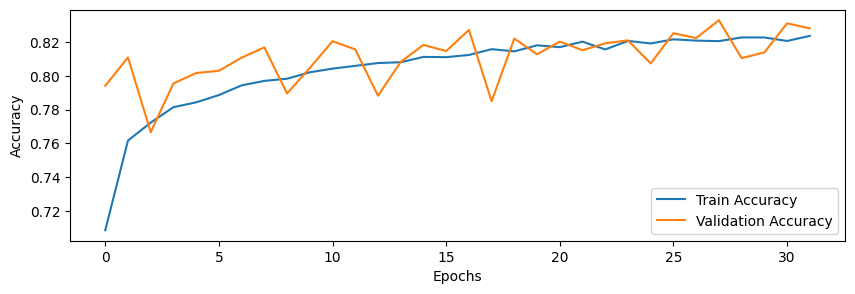

In [20]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 1ms/step


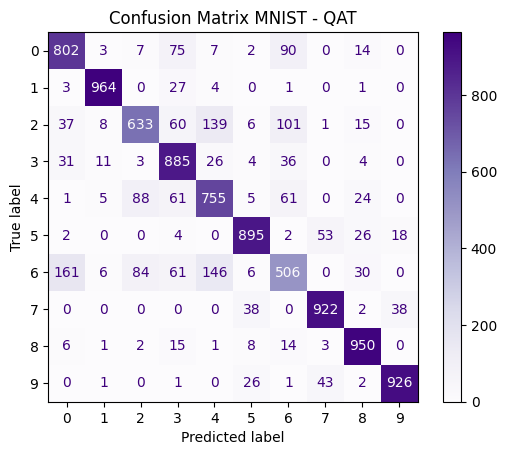

In [21]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - QAT')
plt.show()


---
#### UTP - Perú - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy